In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import glob
import os
import pathlib
import numpy as np
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.utils.data import random_split
import torch.utils.data as data
from torchvision.utils import make_grid
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [2]:
transformer = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

train_path = "/content/drive/MyDrive/Mood_rec/train"
test_path = "/content/drive/MyDrive/Mood_rec/test"

train_loader = DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer),batch_size=256, shuffle=True)
test_loader = DataLoader(torchvision.datasets.ImageFolder(test_path,transform=transformer),batch_size=256, shuffle=True)


In [3]:
root = pathlib.Path(train_path)
classes=sorted([j.name.split("/")[-1] for j in root.iterdir()])
print(classes)

['Fear', 'Happy', 'Sad']


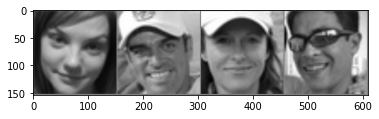

     Happy       Happy       Happy       Happy


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print('  '.join('%5s' % "  "+classes[labels[j]] for j in range(4)))

In [5]:
class ConvNet(nn.Module):
  def __init__(self,num_classes=3):
    super(ConvNet,self).__init__()

    #input_shape = (256,3,150,150)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
    self.bn1=nn.BatchNorm2d(num_features=12)
    self.relu1=nn.ReLU()

    self.pool=nn.MaxPool2d(kernel_size=2)

    self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
    self.relu2=nn.ReLU()

    self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.bn3=nn.BatchNorm2d(num_features=32)
    self.relu3=nn.ReLU()

    self.fc=nn.Linear(in_features=32*75*75,out_features=num_classes)


  def forward(self,input):
    output=self.conv1(input)
    output=self.bn1(output)
    output=self.relu1(output)
    output=self.pool(output)
    output=self.conv2(output)
    output=self.relu2(output)
    output=self.conv3(output)
    output=self.bn3(output)
    output=self.relu3(output)

    output=output.view(-1,32*75*75)

    output=self.fc(output)

    return output


In [6]:
model = ConvNet(num_classes=3).to(device)

In [7]:
optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()
num_epochs=10

In [8]:
train_count = len(glob.glob(train_path+"/**/*.jpg"))
test_count = len(glob.glob(test_path+"/**/*.jpg"))
print(train_count,test_count)

3000 600


In [9]:
best_accuracy = 0.0

for epoch in range(num_epochs):

  model.train()
  train_accuracy = 0.0
  train_loss = 0.0

  for i, (images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
    
    optimizer.zero_grad()

    outputs = model(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()

    train_loss+= loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_accuracy += int(torch.sum(prediction==labels.data))

  train_accuracy = train_accuracy/train_count
  train_loss = train_loss/train_count


  model.eval()
  test_accuracy = 0.0

  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
    outputs= model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+= int(torch.sum(prediction==labels.data))

  test_accuracy = test_accuracy/test_count


  print("Epoch: "+str(epoch)+" Train_Loss: "+str(int(train_loss))[:5]+" Train_Accuracy: "+str(train_accuracy)[:5]+"Test_Accuracy: "+str(test_accuracy)[:5])

  if test_accuracy>best_accuracy:
    torch.save(model.state_dict(),"best_checkpoint.model")
    best_accuracy = test_accuracy



Epoch: 0 Train_Loss: 20 Train_Accuracy: 0.347Test_Accuracy: 0.333
Epoch: 1 Train_Loss: 7 Train_Accuracy: 0.426Test_Accuracy: 0.35
Epoch: 2 Train_Loss: 2 Train_Accuracy: 0.499Test_Accuracy: 0.406
Epoch: 3 Train_Loss: 1 Train_Accuracy: 0.594Test_Accuracy: 0.42
Epoch: 4 Train_Loss: 0 Train_Accuracy: 0.672Test_Accuracy: 0.475
Epoch: 5 Train_Loss: 0 Train_Accuracy: 0.761Test_Accuracy: 0.47
Epoch: 6 Train_Loss: 0 Train_Accuracy: 0.802Test_Accuracy: 0.541
Epoch: 7 Train_Loss: 0 Train_Accuracy: 0.860Test_Accuracy: 0.515
Epoch: 8 Train_Loss: 0 Train_Accuracy: 0.882Test_Accuracy: 0.533
Epoch: 9 Train_Loss: 0 Train_Accuracy: 0.933Test_Accuracy: 0.541


Test Accuracy is low because of the similarity of images. I dont have enough data to classify more correctly. At the same time, i dont have enough compute power to train with more complex CNN structure. Still, we have accuracy more than %50.